In [1]:
from imports import *
from GAIAMdwarfs import *
%matplotlib inline

## cross-match stellar data from NASA archive and GAIA

In [74]:
# get input stellar data and compute parameters using GAIA parallax
def get_stellar_data():
    # cross-match Nasa and GAIA stars
    ids, names, raN, decN, dist, udist, ldist, Teff, uTeff, lTeff, Ms, uMs, lMs, Rs, uRs, lRs, Ls, uLs, lLs, M_H, uM_H, lM_H, Vmag, eVmag, Jmag, eJmag, Hmag, eHmag, Kmag, eKmag = _get_NASA_stellar_data()
    idsG, raG, decG, par, epar = _get_GAIA_stellar_data()
    assert np.all(np.in1d(idsG, ids))
    print 'Number of transiting planets around stars with Teff<=4400 K =', ids.size
    # only keep stars with GAIA parrallaxes and on the MS
    g = (np.isfinite(par)) & (np.isfinite(eKmag)) & (Rs < 1)
    print 'Subset of stars with GAIA parallaxes and photometry =', int(g.sum())
    ids, names, raG, decG = ids[g], names[g], raG[g], decG[g]
    # create unumpy arrays of stellar params from NASA
    #TeffN = unp.uarray(Teff, np.mean(np.array([uTeff,abs(lTeff)]),axis=0))[g]
    #MsN = unp.uarray(Ms, np.mean(np.array([uMs,abs(lMs)]),axis=0))[g]
    #RsN = unp.uarray(Rs, np.mean(np.array([uRs,abs(lRs)]),axis=0))[g]
    #LsN = unp.uarray(Ls, np.mean(np.array([uLs,abs(lLs)]),axis=0))[g]
    #M_HN = unp.uarray(M_H, np.mean(np.array([uM_H,abs(lM_H)]),axis=0))[g]
    #Vmag = unp.uarray(Vmag, eVmag)[g]
    #Jmag = unp.uarray(Jmag, eJmag)[g]
    #Hmag = unp.uarray(Hmag, eHmag)[g]
    #Kmag = unp.uarray(Kmag, eKmag)[g]
    #parG = unp.uarray(par, epar)[g]
    # get GAIA-derived stellar parameters
    #MkG = compute_Mk(Kmag, parG)
    #g2 = unp.nominal_values(MkG) <= 10
    #print 'Subset of stars with Mk<=10 (for MLR) =', g2.sum()
    #assert g2.sum() == Kmag.size  # no stars with Mk>10
    #MsG = compute_Ms_from_Mk(MkG)
    #RsG = compute_Rs_from_Ms(MsG)
    #return ids, names, raG, decG, parG, TeffN, MsN, MsG, RsN, RsG, LsN, M_HN, Vmag, Jmag, Hmag, Kmag, MkG
    return ids,names,raG,decG,par[g],epar[g],dist[g],udist[g],ldist[g],Teff[g],uTeff[g],lTeff[g],Ms[g],uMs[g],lMs[g],\
    Rs[g],uRs[g],lRs[g],Ls[g],uLs[g],lLs[g],Vmag[g],eVmag[g],Jmag[g],eJmag[g],Hmag[g],eHmag[g],Kmag[g],eKmag[g]
    

def _get_NASA_stellar_data():
    d = np.genfromtxt('input_data/NASAexoplanet_Aug222018_stellarv2.csv', skip_header=53, delimiter=',')
    ids,_,_,_,ra,_,dec,dist,udist,ldist,_,Teff,uTeff,lTeff,_,Ms,uMs,lMs,_,Rs,uRs,lRs,_,_,Ls,uLs,lLs,_,M_H,uM_H,lM_H,_,Vmag,eVmag,_,Jmag,eJmag,_,Hmag,eHmag,_,Kmag,eKmag,_ = d.T
    _,names = np.genfromtxt('input_data/NASAexoplanet_Aug222018_stellarv2.csv', skip_header=53, delimiter=',', usecols=(0,1), dtype='|S30').T
    print ids.size, names.size
    assert ids.size == names.size
    return ids, names, ra, dec, dist, udist, ldist, Teff, uTeff, lTeff, Ms, uMs, lMs, Rs, uRs, lRs, Ls, uLs, lLs, M_H, uM_H, lM_H, Vmag, eVmag, Jmag, eJmag, Hmag, eHmag, Kmag, eKmag


def _get_GAIA_stellar_data():
    ids, ra, dec, par, epar = np.loadtxt('input_data/GAIA_query_results.csv', delimiter=',').T
    return ids, ra, dec, par, epar

In [75]:
# compute stellar parameters
def compute_distance(par):
    return rvs.m2pc(rvs.AU2m(1) / unp.radians(par*1e-3/3600))

def compute_Mk(Kmag, par):
    dist_pc = compute_distance(par)
    return Kmag - 5*unp.log10(dist_pc) + 5

def compute_Ms_from_Mk(Mk):
    '''from Eq 11 and Table 13 in Benedict+2016'''
    C0 = unp.uarray(.2311, .0004)
    C1 = unp.uarray(-.1352, .0007)
    C2 = unp.uarray(.04, .0005)
    C3 = unp.uarray(.0038, .0002)
    C4 = unp.uarray(-.0032, .0001)
    x0 = 7.5
    return C0 + C1*(Mk-x0) + C2*(Mk-x0)**2 + C3*(Mk-x0)**3 + C4*(Mk-x0)**4

def compute_Rs_from_Ms(Ms):
    '''Eq 10 in Boyajian+2012'''
    a = unp.uarray(.32, .0165)
    b = unp.uarray(.6063, .0153)
    c = unp.uarray(.0906, .0027)
    return a*Ms*Ms + b*Ms + c


def compute_logLs_from_Rs(Rs):
    a = unp.uarray(4.5169, 0.2265)
    b = unp.uarray(-7.1850, 0.3398)
    c = unp.uarray(6.8639, 0.1562)
    d = unp.uarray(-3.5822, 0.0219)
    return a*Rs**3 + b*Rs**2 + c*Rs + d


def compute_logLs_v2(Rs, Teff):
    return unp.log10(Rs**2 * (Teff/5775.)**4)

## update planet parameters using the new GAIA parallaxes

In [79]:
# get input planetary data
def get_planetary_data():
    # get planet parameters from NASA
    idsP, names, mult, P, uP, lP, sma, usma, lsma, ecc, uecc, lecc, inc, uinc, linc, TTVflag, Kepflag, K2flag, transitflag, RVflag, K, uK, lK, mp, ump, lmp, rp, urp, lrp, depth, udepth, ldepth, dur, udur, ldur, b, ub, lb, rpRs, urpRs, lrpRs = _get_NASA_planetary_data()
    assert idsP.size == 260
    # only keep stars with GAIA parrallaxes and photometry
    ids, names, raN, decN, dist, udist, ldist, Teff, uTeff, lTeff, Ms, uMs, lMs, Rs, uRs, lRs, Ls, uLs, lLs, M_H, uM_H, lM_H, Vmag, eVmag, Jmag, eJmag, Hmag, eHmag, Kmag, eKmag = _get_NASA_stellar_data()
    idsG, raG, decG, parG, eparG = _get_GAIA_stellar_data()
    assert np.all(np.in1d(idsG, ids))
    assert np.all(np.in1d(idsG, idsP))
    g = (np.isfinite(parG)) & (np.isfinite(eKmag)) & (Rs < 1)
    assert g.sum() == 250
    # create unumpy arrays of stellar params from NASA
    #PN = unp.uarray(P, np.mean(np.array([uP,abs(lP)]),axis=0))[g]
    #smaN = unp.uarray(sma, np.mean(np.array([usma,abs(lsma)]),axis=0))[g]
    #eccN = unp.uarray(ecc, np.mean(np.array([uecc,abs(lecc)]),axis=0))[g]
    #incN = unp.uarray(inc, np.mean(np.array([uinc,abs(linc)]),axis=0))[g]
    #TTVflag, Kepflag, K2flag, transitflag, RVflag = TTVflag[g], Kepflag[g], K2flag[g], transitflag[g], RVflag[g]
    #KN = unp.uarray(K, np.mean(np.array([uK,abs(lK)]),axis=0))[g]
    #mpN = unp.uarray(mp, np.mean(np.array([ump,abs(lmp)]),axis=0))[g]
    #rpN = unp.uarray(rp, np.mean(np.array([urp,abs(lrp)]),axis=0))[g]
    #depthN = unp.uarray(depth, np.mean(np.array([udepth,abs(ldepth)]),axis=0))[g]
    #durN = unp.uarray(dur, np.mean(np.array([udur,abs(ldur)]),axis=0))[g]
    #bN = unp.uarray(b, np.mean(np.array([ub,abs(lb)]),axis=0))[g]
    #rpRsN = unp.uarray(rpRs, np.mean(np.array([urpRs,abs(lrpRs)]),axis=0))[g]
    #return ids[g], names[g], PN, smaN, eccN, incN, TTVflag, Kepflag, K2flag, transitflag, RVflag, KN, mpN, rpN, depthN, durN, bN, rpRsN
    return ids[g],names[g],P[g],uP[g],lP[g],sma[g],usma[g],lsma[g],ecc[g],uecc[g],lecc[g],inc[g],uinc[g],linc[g],\
    TTVflag[g],Kepflag[g],K2flag[g],transitflag[g],RVflag[g],K[g],uK[g],lK[g],mp[g],ump[g],lmp[g],rp[g],urp[g],lrp[g],\
    depth[g],udepth[g],ldepth[g],dur[g],udur[g],ldur[g],b[g],ub[g],lb[g],rpRs[g],urpRs[g],lrpRs[g]
    
def _get_NASA_planetary_data():
    d = np.genfromtxt('input_data/NASAexoplanet_Aug222018_planetaryv2.csv', skip_header=70, delimiter=',')
    ids,_,_,mult,P,uP,lP,_,sma,usma,lsma,_,ecc,uecc,lecc,_,inc,uinc,linc,_,_,_,_,_,TTVflag,Kepflag,K2flag,_,_,_,_,transitflag,RVflag,K,uK,lK,_,mp,ump,lmp,_,rp,urp,lrp,_,depth,udepth,ldepth,_,dur,udur,ldur,_,b,ub,lb,_,rpRs,urpRs,lrpRs,_ = d.T
    _,names = np.genfromtxt('input_data/NASAexoplanet_Aug222018_stellarv2.csv', skip_header=53, delimiter=',', usecols=(0,1), dtype='|S30').T
    assert ids.size == names.size
    return ids, names, mult, P, uP, lP, sma, usma, lsma, ecc, uecc, lecc, inc, uinc, linc, TTVflag, Kepflag, K2flag, transitflag, RVflag, K, uK, lK, mp, ump, lmp, rp, urp, lrp, depth, udepth, ldepth, dur, udur, ldur, b, ub, lb, rpRs, urpRs, lrpRs

In [91]:
def get_all_data():
    '''use above functions to read in stellar and planetary parameters together'''
    #ids,names,raG,decG,parG,TeffN,MsN,MsG,RsN,RsG,LsN,M_HN,Vmag,Jmag,Hmag,Kmag,MkG = get_stellar_data()
    ids,names,raG,decG,par,epar,dist,udist,ldist,Teff,uTeff,lTeff,Ms,uMs,lMs,Rs,uRs,lRs,Ls,uLs,lLs,Vmag,eVmag,\
    Jmag,eJmag,Hmag,eHmag,Kmag,eKmag = get_stellar_data()
    #idsP,_,PN,smaN,eccN,incN,TTVflag,Kepflag,K2flag,transitflag,RVflag,KN,mpN,rpN,depthN,durN,bN,rpRsN = get_planetary_data()
    idsP,names,P,uP,lP,sma,usma,lsma,ecc,uecc,lecc,inc,uinc,linc,TTVflag,Kepflag,K2flag,transitflag,RVflag,K,uK,lK,\
    mp,ump,lmp,rp,urp,lrp,depth,udepth,ldepth,dur,udur,ldur,b,ub,lb,rpRs,urpRs,lrpRs = get_planetary_data()
    #g = np.isnan(unp.nominal_values(rpRsN))
    #g = np.isnan(rpRs)
    #rpRs[g] = (rvs.Rearth2m(rp) / rvs.Rsun2m(Rs))[g]
    assert ids.size == idsP.size
    #assert np.all(np.isfinite(unp.nominal_values(rpN)))
    #assert np.all(np.isfinite(unp.std_devs(rpN)))
    assert np.all(np.isfinite(rp))
    assert np.all(np.isfinite(rp))
    # get new planet params
    #mpG = compute_mp(PN, MsG, KN, eccN, incN)
    #rpG = compute_rp(rpRsN, RsG)
    #return ids,names,raG,decG,parG,TeffN,MsN,MsG,RsN,RsG,LsN,M_HN,Vmag,Jmag,Hmag,Kmag,MkG,PN,smaN,eccN,incN,TTVflag,Kepflag,K2flag,transitflag,RVflag,KN,mpN,mpG,rpN,rpG,rpRsN,depthN,durN,bN
    return ids,names,raG,decG,par,epar,dist,udist,abs(ldist),Teff,uTeff,abs(lTeff),Ms,uMs,abs(lMs),Rs,uRs,abs(lRs),\
    Ls,uLs,abs(lLs),Vmag,eVmag,Jmag,eJmag,Hmag,eHmag,Kmag,eKmag,P,uP,abs(lP),sma,usma,abs(lsma),ecc,uecc,abs(lecc),\
    inc,uinc,abs(linc),TTVflag,Kepflag,K2flag,transitflag,RVflag,K,uK,abs(lK),mp,ump,abs(lmp),rp,urp,abs(lrp),\
    rpRs,urpRs,abs(lrpRs),depth,udepth,abs(ldepth),dur,udur,abs(ldur),b,ub,abs(lb)
    
    
def compute_rp(rpRs, Rs):
    return rvs.m2Rearth(rvs.Rsun2m(rpRs*Rs))
    
    
def compute_mp(Ps, Ms, K, ecc, inc):
    ecc[np.isnan(unp.nominal_values(ecc))] = 0.
    inc[np.isnan(unp.nominal_values(inc))] = 90.
    return rvs.RV_mp(Ps, Ms, K, ecc, inc)

## get input data and compute planet parameters 

In [119]:
# get input data
#ids,names,raG,decG,parG,TeffN,MsN,MsG,RsN,RsG,LsN,M_HN,\
#Vmag,Jmag,Hmag,Kmag,MkG,PN,smaN,eccN,incN,TTVflag,Kepflag,K2flag,transitflag,RVflag,\
#KN,mpN,mpG,rpN,rpG,rpRsN,depthN,durN,bN = get_all_data()
ids,names,raG,decG,par,epar,dist,udist,ldist,Teff,uTeff,lTeff,Ms,uMs,lMs,Rs,uRs,lRs,Ls,uLs,lLs,Vmag,eVmag,Jmag,eJmag,\
Hmag,eHmag,Kmag,eKmag,P,uP,lP,sma,usma,lsma,ecc,uecc,lecc,inc,uinc,linc,TTVflag,Kepflag,K2flag,transitflag,RVflag,\
K,uK,lK,mp,ump,lmp,rp,urp,lrp,rpRs,urpRs,lrpRs,depth,udepth,ldepth,dur,udur,ldur,b,ub,lb = get_all_data()

260 260
Number of transiting planets around stars with Teff<=4400 K = 260
Subset of stars with GAIA parallaxes and photometry = 250
260 260


In [120]:
# create new table and save for easy access and editting of NASA archive values
hdr = '00: ID\n01: RA [deg]\n02: Dec [deg]\n03: GAIA Parallax [mas]\n04: e\n05: Teff [K]\n06: e\n'
hdr += '07: Ms [MSun]\n08: e\n09: Rs [RSun]\n10: e\n11: Ls [LSun]\n12: e\n13: Vmag []\n14: e\n'
hdr += '15: Jmag []\n16: e\n17: Hmag []\n18: e\n19: Kmag []\n20: e\n21: P [days]\n22: e\n'
hdr += '23: a [AU]\n24: e\n25: ecc []\n26: e\n27: inc [deg]\n28: e\n29: K [m/s]\n30: e\n'
hdr += '31: mp [MEarth]\n32: e\n33: rp [REarth]\n34: e\n35: rpRs []\n36: e'
self = GAIAMdwarfs('input_data/GAIAMdwarfs_fullerrors')
self.ids, self.names, self.N, self.G = ids, names, 'from the NASA exoplanet archive', 'measured from the GAIA parallax'
self.raG, self.decG = raG, decG
self.parallaxG, self.eparallaxG, self.distN, self.udistN, self.ldistN = par, epar, dist, udist, ldist
self.TeffN, self.uTeffN, self.lTeffN = Teff, uTeff, lTeff
self.MsN, self.uMsN, self.lMsN = Ms, uMs, lMs
self.RsN, self.uRsN, self.lRsN = Rs, uRs, lRs
self.LsN, self.uLsN, self.lLsN = Ls, uLs, lLs
#self.LsN_LRR = compute_logLs_from_Rs(self.Rs)
self.TTVflag, self.RVflag = TTVflag, RVflag
self.Vmag, self.eVmag, self.Jmag, self.eJmag = Vmag, eVmag, Jmag, eJmag
self.Hmag, self.eHmag, self.Kmag, self.eKmag = Hmag, eHmag, Kmag, eKmag
self.Ps, self.uPs, self.lPs = P, uP, lP
self.smasN, self.usmasN, self.lsmasN = sma, usma, lsma
self.eccs, self.ueccs, self.leccs = ecc, uecc, lecc
self.incs, self.uincs, self.lincs = inc, uinc, linc
self.Ks, self.uKs, self.lKs = K, uK, lK
self.mpsN, self.umpsN, self.lmpsN = mp, ump, lmp
self.rpsN, self.urpsN, self.lrpsN = rp, urp, lrp
self.rpRs, self.urpRs, self.lrpRs = rpRs, urpRs, lrpRs
# calculate rp from rp/Rs * Rs
urpRs, lrpRs = unp.uarray(rpRs, urpRs), unp.uarray(rpRs, lrpRs)
uRs, lRs = unp.uarray(Rs, uRs), unp.uarray(Rs, lRs)
urp, lrp = rvs.m2Rearth(rvs.Rsun2m(urpRs*uRs)), rvs.m2Rearth(rvs.Rsun2m(lrpRs*lRs))
self.rpsN_calc, self.urpsN_calc, self.lrpsN_calc = unp.nominal_values(urp), unp.std_devs(urp), unp.std_devs(lrp)
self._pickleoject()

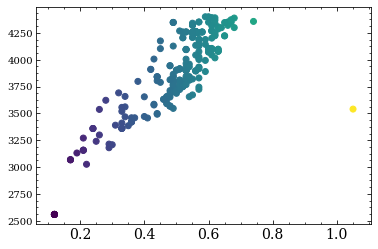

In [25]:
# add missing fields here
i = 0
plt.scatter(unp.nominal_values(self.RsN), unp.nominal_values(self.TeffN), c=unp.nominal_values(self.LsN_LRR))

In [34]:
# save
print output.shape
fmt = ('%.1f,%.6f,%.6f,%.12f,%.12f,%.1f,%.1f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.5f,%.5f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f,%.3f')
assert fmt.count(',') == output.shape[1]-1
np.savetxt('input_data/NASAGAIA_table_full.csv', output, delimiter=',', fmt=fmt, header=hdr)

(250, 37)


([<matplotlib.lines.Line2D at 0x11c45acd0>], (0.1, 15), (0.1, 15))

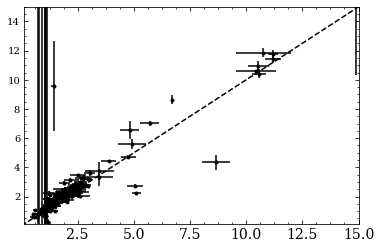

In [278]:
plt.errorbar(unp.nominal_values(rpN), unp.nominal_values(rpG), 
             xerr=unp.std_devs(rpN), yerr=unp.std_devs(rpG), fmt='k.')
plt.plot([0,15],[0,15],'k--'), plt.xlim((.1,15)), plt.ylim((.1,15))

In [280]:
rpN.size

250

((0, 0.8), (0, 0.8))

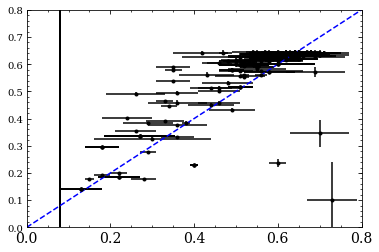

In [228]:
# compare stellar masses
plt.errorbar(unp.nominal_values(MsN), unp.nominal_values(MsG), xerr=unp.std_devs(MsN), 
             yerr=unp.std_devs(MsG), fmt='k.')
plt.plot([0,.8], [0,.8], 'b--')
plt.xlim((0,.8)), plt.ylim((0,.8))